In [1]:
import os
import re
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta



def process_log_file(full_path):
    if os.stat(full_path).st_size == 0:
        print(f"Skipping empty file: {full_path}")
        return pd.DataFrame()

    with open(full_path, 'r') as file:
        data = []
        for line in file:
            match = re.search(r'(\d+\.\d+).*Throughput @(\d+\.\d+)s:\s+(\d+\.\d+)Gbps, lossRate: (\d+\.\d+|\d+)\s+parallelism:(\d+)\s+concurrency:(\d+)\s+score:(-?\d+\.\d+)\s+rtt:(\d+\.\d+) ms energy:(\d+\.\d+) Jules s-plr:([\deE.-]+)', line)
            if match:
                time = datetime.fromtimestamp(float(match.group(1)))
                throughput = float(match.group(3))
                loss_rate = float(match.group(4))
                parallelism = int(match.group(5))
                concurrency = int(match.group(6))
                score = float(match.group(7))
                rtt = float(match.group(8))
                energy = float(match.group(9))
                sender_lr = float(match.group(10))

                data.append([time, throughput, loss_rate, parallelism, concurrency, score, rtt, energy, sender_lr])

        if data:
            df = pd.DataFrame(data, columns=['Time', 'Throughput', 'LossRate', 'Parallelism', 'Concurrency', 'Score', 'RTT', 'Energy', 'SenderLR'])
        else:
            df = pd.DataFrame()
            print(f"No valid data in file: {full_path}")

    return df

def process_directory(directory_path):
    all_dfs = []  # List to hold all DataFrames from each log file
    for filename in os.listdir(directory_path):
        # Construct the full path to the file
        full_path = os.path.join(directory_path, filename)
        # Check if it's a file and has a log extension (if your log files have a specific extension)
        if os.path.isfile(full_path):  # and filename.endswith(".log"):
            print(f"Processing file: {filename}")
            df = process_log_file(full_path)
            if not df.empty:
                all_dfs.append(df)
            else:
                print(f"Empty or invalid data in file: {filename}")

    # Concatenate all DataFrames if not empty
    if all_dfs:
        final_df = pd.concat(all_dfs, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data was found

def print_empty_dataframes(dfs):
    total_rows=0
    for key, df in dfs.items():
        if df.empty:
            print(f"The DataFrame for key '{key}' is empty.")
        else:
            num_rows = len(df)
            total_rows+=num_rows
            print(f"The DataFrame for key '{key}' has {num_rows} rows")
    print(f"\n\n\nThere are toatl {total_rows} rows in all the transitions dictionaries")


import pandas as pd

def find_transitions_tuple_based(df, col1, col2, old_tuple, target_tuple):
    # Create a new empty DataFrame with the same columns
    new_df = pd.DataFrame(columns=df.columns)
    # Flag to mark if we are currently in a transition block
    in_transition = False
    # Iterate through the DataFrame
    for index, row in df.iterrows():
        # Check for transition start
        if row[col1] == old_tuple[0] and row[col2] == old_tuple[1] and not in_transition:
            in_transition = True
        # Check for transition end
        elif row[col1] == target_tuple[0] and row[col2] == target_tuple[1] and in_transition:
            new_df = new_df.append(row)
        # If the value is neither start nor target, reset the flag
        elif row[col1] != old_tuple[0] or row[col2] != old_tuple[1]:
            in_transition = False

    return new_df.reset_index(drop=True)


def filter_df_by_value_tuple(df_original, column_name_1, column_name_2, value_tuple):
    """
    Filters the DataFrame based on specific values in two given columns and creates an independent copy.

    :param df_original: The original DataFrame.
    :param column_name_1: The name of the first column to filter on.
    :param column_name_2: The name of the second column to filter on.
    :param value_tuple: A tuple containing the values to filter by in the specified columns.
    :return: A new DataFrame containing rows where each column matches its corresponding value in value_tuple.
    """
    filtered_df = df_original[(df_original[column_name_1] == value_tuple[0]) & (df_original[column_name_2] == value_tuple[1])].copy()
    return filtered_df



def sample_row_and_neighbors(df, column_name):
    """
    Samples a row based on the distribution of a specific column and returns it with its 4 neighboring rows.
    If fewer than 5 rows are returned, the function duplicates rows to ensure 5 rows are returned.

    :param df: The DataFrame to sample from.
    :param column_name: The column whose distribution to use for sampling.
    :return: A DataFrame containing the sampled row and its 4 neighbors, ensuring 5 rows in total.
    """
    # Ensure the DataFrame's index is reset
    df = df.reset_index(drop=True)
    # Calculate the frequency distribution of the column
    probabilities = df[column_name].value_counts(normalize=True)
    # Map these probabilities back to the DataFrame's index
    probabilities = df[column_name].map(probabilities)
    # Sample one row using these probabilities
    sampled_row = df.sample(n=1, weights=probabilities)
    sampled_index = sampled_row.index[0]

    # Ensure the sampled index is within the DataFrame's range
    if sampled_index >= len(df):
        raise ValueError("Sampled index is out of DataFrame's range.")

    # Attempt to select 2 neighbors from each side
    start_index = max(sampled_index - 2, 0)
    end_index = min(sampled_index + 2, len(df) - 1)
    selected_rows = df.iloc[start_index:end_index + 1]

    # If fewer than 5 rows are selected, duplicate rows to reach 5
    while len(selected_rows) < 5:
        if start_index > 0:
            start_index -= 1
        elif end_index < len(df) - 1:
            end_index += 1
        else:
            # If start and end indices cover the whole DataFrame, duplicate the last row
            selected_rows = pd.concat([selected_rows, selected_rows.iloc[[-1]]], ignore_index=True)
        # Update selected_rows if indices were adjusted
        if len(selected_rows) < 5:
            selected_rows = df.iloc[start_index:end_index + 1]

    return selected_rows


def normalize_and_flatten(df, min_values, max_values):
    # Drop the specified columns
    df = df.drop(columns=['Time'])
    score_array = df['Score'].values
    energy_array=df['Energy'].values
    throughput_array=df['Throughput'].values
#     print(df.describe())
    # Normalize each column
    normalized_df = (df - min_values) / (max_values - min_values)

    # Flatten the DataFrame to a single NumPy array
    flattened_array = normalized_df.values.flatten()

    return flattened_array,score_array,energy_array,throughput_array


/tmp/ipykernel_435664/3714429324.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Matplotlib created a temporary cache directory at /tmp/matplotlib-59mdqyby because the default path (/home/cc/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
!pwd

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
pwd: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [5]:
directory="/home/cc/transferService/RL_agents/PPO_self_implementation/logFiles/logFileDir_m_action_i_d/PPO_MA/"
df=process_directory(directory)

Processing file: PPO_MA_logFile_02_04_2024_20_48_43.log


In [6]:

print("##################################################################")
print("Original df")
print("##################################################################")
print(df.describe())
# Get minimum values of each column as a NumPy array
min_values = df.min().values

# Get maximum values of each column as a NumPy array
max_values = df.max().values

print(f'min_values : {min_values[1:]}')
print(f'max_values : {max_values[1:]}')


df= df[(df['Throughput'] != 0)]
df.reset_index(drop=True, inplace=True)
print("##################################################################")
print("df after removing throughput ==0 rows")
print("##################################################################")
print(df.describe())
# Get minimum values of each column as a NumPy array
min_values = df.min().values

# Get maximum values of each column as a NumPy array
max_values = df.max().values

print(f'min_values : {min_values[1:]}')
print(f'max_values : {max_values[1:]}')


df= df[(df['Energy'] != 0)]
df.reset_index(drop=True, inplace=True)
print("##################################################################")
print("df after removing Energy ==0 rows")
print("##################################################################")
print(df.describe())
# Get minimum values of each column as a NumPy array
min_values = df.min().values

# Get maximum values of each column as a NumPy array
max_values = df.max().values

print(f'min_values : {min_values[1:]}')
print(f'max_values : {max_values[1:]}')

##################################################################
Original df
##################################################################
                                Time     Throughput       LossRate  \
count                         156277  156277.000000  156277.000000   
mean   2024-02-05 18:40:53.713178624       3.399627       0.000051   
min       2024-02-04 20:48:46.693160       0.000000       0.000000   
25%    2024-02-05 07:44:59.785399040       0.320000       0.000000   
50%    2024-02-05 18:40:51.161977088       2.560000       0.000000   
75%    2024-02-06 05:37:16.087228928       5.760000       0.000000   
max       2024-02-06 16:31:54.458912      17.600000       6.000000   
std                              NaN       3.303315       0.015256   

         Parallelism    Concurrency          Score            RTT  \
count  156277.000000  156277.000000  156277.000000  156277.000000   
mean        4.898833       4.876431       3.176085      31.330766   
min         1.00

In [7]:
# Creating a Series of tuples from 'column1' and 'column2'
tuples_series = df.apply(lambda row: (row['Parallelism'], row['Concurrency']), axis=1)
unique_tuples_count = tuples_series.nunique()
print(f"Total {unique_tuples_count} number of tuples")
# Getting all unique tuples
unique_tuples = tuples_series.unique()
sorted_tuples_list = sorted(unique_tuples)

print(sorted_tuples_list)

Total 64 number of tuples
[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8)]


In [ ]:

# Example DataFrame
data = {
    'column1': ['v1', 'v3', 'v4', 'v4', 'v4', 'v1', 'v1', 'v1', 'v3', 'v4', 'v4', 'v4'],
    'column2': ['v1', 'v4', 'v5', 'v5', 'v5', 'v2', 'v2', 'v2', 'v4', 'v5', 'v5', 'v5']
}
df_ = pd.DataFrame(data)

# Using the function with specified arguments
result_df = find_transitions_tuple_based(df_, 'column1', 'column2', ('v3', 'v4'), ('v4', 'v5'))

print(result_df)


In [9]:

count=0
cluster_dictionary={}
for tuple1 in range (31,len(sorted_tuples_list)):
    for tuple2 in range (len(sorted_tuples_list)):
        if tuple1==tuple2:
            continue
        else:
            count+=1
            print(sorted_tuples_list[tuple1],sorted_tuples_list[tuple2])
print(f"Total count {count}")

(4, 8) (1, 1)
(4, 8) (1, 2)
(4, 8) (1, 3)
(4, 8) (1, 4)
(4, 8) (1, 5)
(4, 8) (1, 6)
(4, 8) (1, 7)
(4, 8) (1, 8)
(4, 8) (2, 1)
(4, 8) (2, 2)
(4, 8) (2, 3)
(4, 8) (2, 4)
(4, 8) (2, 5)
(4, 8) (2, 6)
(4, 8) (2, 7)
(4, 8) (2, 8)
(4, 8) (3, 1)
(4, 8) (3, 2)
(4, 8) (3, 3)
(4, 8) (3, 4)
(4, 8) (3, 5)
(4, 8) (3, 6)
(4, 8) (3, 7)
(4, 8) (3, 8)
(4, 8) (4, 1)
(4, 8) (4, 2)
(4, 8) (4, 3)
(4, 8) (4, 4)
(4, 8) (4, 5)
(4, 8) (4, 6)
(4, 8) (4, 7)
(4, 8) (5, 1)
(4, 8) (5, 2)
(4, 8) (5, 3)
(4, 8) (5, 4)
(4, 8) (5, 5)
(4, 8) (5, 6)
(4, 8) (5, 7)
(4, 8) (5, 8)
(4, 8) (6, 1)
(4, 8) (6, 2)
(4, 8) (6, 3)
(4, 8) (6, 4)
(4, 8) (6, 5)
(4, 8) (6, 6)
(4, 8) (6, 7)
(4, 8) (6, 8)
(4, 8) (7, 1)
(4, 8) (7, 2)
(4, 8) (7, 3)
(4, 8) (7, 4)
(4, 8) (7, 5)
(4, 8) (7, 6)
(4, 8) (7, 7)
(4, 8) (7, 8)
(4, 8) (8, 1)
(4, 8) (8, 2)
(4, 8) (8, 3)
(4, 8) (8, 4)
(4, 8) (8, 5)
(4, 8) (8, 6)
(4, 8) (8, 7)
(4, 8) (8, 8)
(5, 1) (1, 1)
(5, 1) (1, 2)
(5, 1) (1, 3)
(5, 1) (1, 4)
(5, 1) (1, 5)
(5, 1) (1, 6)
(5, 1) (1, 7)
(5, 1) (1, 8)
(5, 1)

In [ ]:
# result_df = find_transitions_tuple_based(df, 'Parallelism', 'Concurrency', (1, 1), (1, 4))

# print(result_df)


In [ ]:
# import time
# start_time = time.time()

# count=0
# cluster_dictionary={}
# for tuple1 in range (len(sorted_tuples_list)):
#     for tuple2 in range (len(sorted_tuples_list)):
#         if tuple1==tuple2:
#             continue
#         else:
#             count+=1
# #             print(sorted_tuples_list[tuple1],sorted_tuples_list[tuple2])
#             cluster_dictionary[sorted_tuples_list[tuple1],sorted_tuples_list[tuple2]]= find_transitions_tuple_based(df, 'Parallelism', 'Concurrency', sorted_tuples_list[tuple1], sorted_tuples_list[tuple2])
# print(f"Total count {count}")
# print(cluster_dictionary)
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Elapsed time: {elapsed_time} seconds")
# import pickle
# with open('dataframes_multi_action.pickle', 'wb') as handle:
#     pickle.dump(cluster_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
import pickle
with open('dataframes_multi_action.pickle', 'rb') as handle:
    cluster_dictionary = pickle.load(handle)

print_empty_dataframes(cluster_dictionary)

The DataFrame for key '((1, 1), (1, 2))' has 18 rows
The DataFrame for key '((1, 1), (1, 3))' is empty.
The DataFrame for key '((1, 1), (1, 4))' has 21 rows
The DataFrame for key '((1, 1), (1, 5))' has 20 rows
The DataFrame for key '((1, 1), (1, 6))' has 28 rows
The DataFrame for key '((1, 1), (1, 7))' is empty.
The DataFrame for key '((1, 1), (1, 8))' has 28 rows
The DataFrame for key '((1, 1), (2, 1))' is empty.
The DataFrame for key '((1, 1), (2, 2))' has 10 rows
The DataFrame for key '((1, 1), (2, 3))' has 10 rows
The DataFrame for key '((1, 1), (2, 4))' has 20 rows
The DataFrame for key '((1, 1), (2, 5))' has 36 rows
The DataFrame for key '((1, 1), (2, 6))' has 34 rows
The DataFrame for key '((1, 1), (2, 7))' is empty.
The DataFrame for key '((1, 1), (2, 8))' is empty.
The DataFrame for key '((1, 1), (3, 1))' has 38 rows
The DataFrame for key '((1, 1), (3, 2))' has 18 rows
The DataFrame for key '((1, 1), (3, 3))' has 10 rows
The DataFrame for key '((1, 1), (3, 4))' is empty.
The D

In [ ]:


# initial_value_cluster_dictionary={}
# column_name_1='Parallelism'
# column_name_2='Concurrency'
# for tuple_ in sorted_tuples_list:
#     initial_value_cluster_dictionary[tuple_]=filter_df_by_value_tuple(df, column_name_1, column_name_2, tuple_)

# with open('initial_dataframes_multi_action.pickle', 'wb') as handle:
#     pickle.dump(initial_value_cluster_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [8]:
with open('initial_dataframes_multi_action.pickle', 'rb') as handle:
    initial_value_cluster_dictionary = pickle.load(handle)

print_empty_dataframes(initial_value_cluster_dictionary)

The DataFrame for key '(1, 1)' has 1073 rows
The DataFrame for key '(1, 2)' has 1212 rows
The DataFrame for key '(1, 3)' has 1292 rows
The DataFrame for key '(1, 4)' has 1418 rows
The DataFrame for key '(1, 5)' has 1492 rows
The DataFrame for key '(1, 6)' has 1488 rows
The DataFrame for key '(1, 7)' has 1511 rows
The DataFrame for key '(1, 8)' has 1312 rows
The DataFrame for key '(2, 1)' has 844 rows
The DataFrame for key '(2, 2)' has 962 rows
The DataFrame for key '(2, 3)' has 1157 rows
The DataFrame for key '(2, 4)' has 1241 rows
The DataFrame for key '(2, 5)' has 1232 rows
The DataFrame for key '(2, 6)' has 1333 rows
The DataFrame for key '(2, 7)' has 1221 rows
The DataFrame for key '(2, 8)' has 1021 rows
The DataFrame for key '(3, 1)' has 997 rows
The DataFrame for key '(3, 2)' has 1463 rows
The DataFrame for key '(3, 3)' has 1354 rows
The DataFrame for key '(3, 4)' has 1810 rows
The DataFrame for key '(3, 5)' has 2576 rows
The DataFrame for key '(3, 6)' has 2717 rows
The DataFrame

In [ ]:
initial_value_cluster_dictionary[(7,1)]

In [ ]:
y1=(4,2)
y2=( 4, 2)
if y1==y2:
    print("True")
else:
    print("False")


In [9]:
import gym
from gym import spaces
import numpy as np



class transferClass_multi_action_increase_decrease(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}
    def __init__(self,transaction_dfs,initial_dfs,optimizer,total_steps=20,min_values=[0.32, 0.0, 1, 1, -268.0, 0.0, 43.0, 0.0],max_values = [17.6, 6.0, 8, 8, 16.0, 103.0, 102.0, 6.6],total_file_size=256):
        super().__init__()
        self.min_action=1
        self.max_action=8
        self.action_i_d_array=[1,4,0,-1,-4]

        self.transaction_dfs = transaction_dfs
        self.initial_dfs= initial_dfs

        self.action_space = spaces.MultiDiscrete([5, 5])  # example action space
        self.current_action_parallelism_value=1
        self.current_action_concurrency_value=1
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(40,), dtype=np.float32) # example observation space
        self.current_observation = np.zeros(40,) # initialize current observation

        self.optimizer=optimizer
        self.old_action=None
        self.step_number=0
        self.total_steps=total_steps
        self.sampling_metric='Score'
        self.min_values=np.array(min_values)
        self.max_values=np.array(max_values)
        self.previous_reward=0
        self.obs_df=[]
        self.total_file_size= total_file_size
        self.current_download_size=0

    def reset(self):
        self.current_observation = np.zeros(40,) # initialize current observation
        self.old_action=None
        self.step_number=0
        self.previous_reward=0
        self.current_action_parallelism_value=1
        self.current_action_concurrency_value=1
        self.obs_df=[]
        self.current_download_size=0
        return self.current_observation

    def step(self, action):
        # perform action using transfer_service
        action_1,action_2=action

        self.current_action_parallelism_value+=self.action_i_d_array[action_1]
        if self.current_action_parallelism_value<self.min_action:
            self.current_action_parallelism_value=self.min_action
        elif self.current_action_parallelism_value>self.max_action:
            self.current_action_parallelism_value=self.max_action

        self.current_action_concurrency_value+=self.action_i_d_array[action_2]
        if self.current_action_concurrency_value<self.min_action:
            self.current_action_concurrency_value=self.min_action
        elif self.current_action_concurrency_value>self.max_action:
            self.current_action_concurrency_value=self.max_action


        action_t=(self.current_action_parallelism_value,self.current_action_concurrency_value)
#         print(f"action_t {action_t}")

        if self.old_action==None:
            done=False
            observation_df=sample_row_and_neighbors(self.initial_dfs[action_t],self.sampling_metric)
            self.obs_df.append(observation_df)
            observation,result_array,e_array,t_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            self.current_download_size+=np.sum(t_array)
            reward_=np.mean(result_array)
            self.old_action=action_t
            reward=reward_-self.previous_reward
            self.previous_reward=reward_

        elif self.old_action==action_t:
            done=False
            observation_df=sample_row_and_neighbors(self.initial_dfs[action_t],self.sampling_metric)
            self.obs_df.append(observation_df)
            observation,result_array,e_array,t_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            self.current_download_size+=np.sum(t_array)
            reward_=np.mean(result_array)
            self.old_action=action_t
            reward=reward_-self.previous_reward
            self.previous_reward=reward_

        else:
            done=False
            key_name=(self.old_action, action_t)
            work_df=self.transaction_dfs[key_name]
            if work_df.empty:
                observation_df=sample_row_and_neighbors(self.initial_dfs[action_t],self.sampling_metric)
            else:
                observation_df=sample_row_and_neighbors(self.transaction_dfs[key_name],self.sampling_metric)
            self.obs_df.append(observation_df)
            observation,result_array,e_array,t_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            self.current_download_size+=np.sum(t_array)
            reward_=np.mean(result_array)
            self.old_action=action_t
            reward=reward_-self.previous_reward
            self.previous_reward=reward_

        self.step_number+=1

        # if self.step_number>=self.total_steps:
        #     done=True
        if self.current_download_size>=self.total_file_size:
            done=True
#             reward=100
        observation = np.asarray(observation).astype(np.float32)
        self.current_observation=observation

        return self.current_observation, reward, done, {}

    def bayes_step(self,action):
        params = [1 if x<1 else int(np.round(x)) for x in action]
        self.current_action_array_index+=self.action_i_d_array[params[0]]
        if self.current_action_array_index<self.min_action:
            self.current_action_array_index=self.min_action
        elif self.current_action_array_index>self.max_action:
            self.current_action_array_index=self.max_action
        action_t=self.action_array[self.current_action_array_index]

        print("Bayes Step: ",action_t)
        obs,score_b,done_b,__=self.step(action_t)
        print("Bayes Step Score: ", score_b)
        return np.round(score_b * (-1))

    def render(self, mode="human"):
        pass

    def close(self):
        self.reset()


In [10]:
env=transferClass_multi_action_increase_decrease(cluster_dictionary,initial_value_cluster_dictionary,'random')
total_scores=0
s = env.reset()
action_list=[]
reward_list=[]
done = False
while not done:
    a=env.action_space.sample()
    s_next, r, done, info = env.step(a)
    print( len(s_next))
    action_list.append(a)
    reward_list.append(r)
    total_scores += r
    s = s_next
accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed

env.close()
print(f"Total Reward: {total_scores}")
print(f"actions {action_list},   {len(action_list)}")
print(f"rewards {reward_list},  {len(reward_list)}")
print(accumulator_df)
print(f"Total downloaded {accumulator_df['Throughput'].sum()} Gb")
print(f"Download speed {accumulator_df['Throughput'].mean()} Gbps")

40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
Total Reward: 3.0
actions [array([1, 3]), array([0, 2]), array([1, 3]), array([0, 2]), array([1, 3]), array([3, 0]), array([0, 3]), array([4, 0]), array([4, 2]), array([2, 2]), array([2, 0]), array([0, 3]), array([1, 2]), array([4, 4]), array([1, 3]), array([3, 3]), array([4, 3]), array([2, 4]), array([0, 2]), array([4, 3]), array([4, 4]), array([1, 0]), array([2, 4]), array([2, 4]), array([3, 0])],   25
rewards [2.2, 0.3999999999999999, 0.6000000000000001, -0.40000000000000036, 0.20000000000000018, 0.20000000000000018, -2.2, -1.0, 2.8, -1.7999999999999998, -1.0, 1.0, 0.6000000000000001, 0.7999999999999998, -1.4, 1.6, -0.6000000000000001, -0.6000000000000001, 0.0, 0.6000000000000001, -1.2, 1.2, 0.7999999999999998, 3.2, -3.0],  25
                          Time  Throughput  LossRate Parallelism Concurrency  \
946 2024-02-06 10:50:36.174871        2.24       0.0           5           1   
947 2024-02-06 10:50:37.1

In [ ]:
import sys
import copy
import random
import time
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback,CheckpointCallback,CallbackList
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

env=transferClass_multi_action_increase_decrease(cluster_dictionary,initial_value_cluster_dictionary,'random')
evaluation_env=transferClass_multi_action_increase_decrease(cluster_dictionary,initial_value_cluster_dictionary,'random')

policy_kwargs = dict(activation_fn=th.nn.ReLU,net_arch=[{'pi': [128, 128], 'vf': [128, 128]}])

run_string='multi_action_in_de'
model = PPO("MlpPolicy", env=env, policy_kwargs=policy_kwargs, verbose=1,tensorboard_log=f"./ppo_tensorboard_{run_string}/",ent_coef=0.01)

eval_callback = EvalCallback(evaluation_env, best_model_save_path=f'./ppo_{run_string}/ppo_best_model/',
                               log_path=f'./ppo_{run_string}/ppo_logs/', eval_freq=1000,
                               deterministic=True, render=False)
# Callback for saving checkpoints every 1000 timesteps
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path=f'./ppo_{run_string}/ppo_checkpoints/',
                                           name_prefix=f'ppo_model_{run_string}')

# Combine both callbacks
callback = CallbackList([checkpoint_callback, eval_callback])
model.learn(total_timesteps=1000000, callback=callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


2024-02-07 22:27:33.248664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-07 22:27:33.471389: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 22:27:34.773555: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/cv2/../../lib64:
2024-02-07 22:27:34.773619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not loa

Logging to ./ppo_tensorboard_multi_action_in_de/PPO_3


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1000, episode_reward=5.00 +/- 0.57
Episode length: 16.80 +/- 2.64
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16.8     |
|    mean_reward     | 5        |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2000, episode_reward=4.20 +/- 0.46
Episode length: 17.00 +/- 1.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 17       |
|    mean_reward     | 4.2      |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 4.7      |
| time/              |          |
|    fps             | 110      |
|    iterations      | 1        |
|    time_elapsed    | 18       |
|    total_timesteps | 2048     |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=3000, episode_reward=4.48 +/- 1.24
Episode length: 12.00 +/- 1.10
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 12          |
|    mean_reward          | 4.48        |
| time/                   |             |
|    total_timesteps      | 3000        |
| train/                  |             |
|    approx_kl            | 0.009479488 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.21       |
|    explained_variance   | 0.0426      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.24        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0119     |
|    value_loss           | 3.71        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4000, episode_reward=4.44 +/- 1.53
Episode length: 12.40 +/- 2.15
---------------------------------
| eval/              |          |
|    mean_ep_length  | 12.4     |
|    mean_reward     | 4.44     |
| time/              |          |
|    total_timesteps | 4000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.1     |
|    ep_rew_mean     | 4.66     |
| time/              |          |
|    fps             | 114      |
|    iterations      | 2        |
|    time_elapsed    | 35       |
|    total_timesteps | 4096     |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=3.48 +/- 2.64
Episode length: 14.80 +/- 1.17
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 14.8        |
|    mean_reward          | 3.48        |
| time/                   |             |
|    total_timesteps      | 5000        |
| train/                  |             |
|    approx_kl            | 0.009902608 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.2        |
|    explained_variance   | 0.615       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.701       |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0167     |
|    value_loss           | 2.02        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6000, episode_reward=4.88 +/- 2.29
Episode length: 16.00 +/- 2.53
---------------------------------
| eval/              |          |
|    mean_ep_length  | 16       |
|    mean_reward     | 4.88     |
| time/              |          |
|    total_timesteps | 6000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | 5.29     |
| time/              |          |
|    fps             | 116      |
|    iterations      | 3        |
|    time_elapsed    | 52       |
|    total_timesteps | 6144     |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=7000, episode_reward=5.52 +/- 1.37
Episode length: 18.00 +/- 3.16
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 18          |
|    mean_reward          | 5.52        |
| time/                   |             |
|    total_timesteps      | 7000        |
| train/                  |             |
|    approx_kl            | 0.008834204 |
|    clip_fraction        | 0.0842      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.18       |
|    explained_variance   | 0.566       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.19        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 2.92        |
-----------------------------------------
New best mean reward!


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8000, episode_reward=4.36 +/- 2.74
Episode length: 15.80 +/- 3.43
---------------------------------
| eval/              |          |
|    mean_ep_length  | 15.8     |
|    mean_reward     | 4.36     |
| time/              |          |
|    total_timesteps | 8000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.3     |
|    ep_rew_mean     | 5.01     |
| time/              |          |
|    fps             | 115      |
|    iterations      | 4        |
|    time_elapsed    | 70       |
|    total_timesteps | 8192     |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=9000, episode_reward=6.36 +/- 1.14
Episode length: 13.80 +/- 1.33
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 13.8         |
|    mean_reward          | 6.36         |
| time/                   |              |
|    total_timesteps      | 9000         |
| train/                  |              |
|    approx_kl            | 0.0074095423 |
|    clip_fraction        | 0.0788       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.15        |
|    explained_variance   | 0.666        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.22         |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00818     |
|    value_loss           | 2.49         |
------------------------------------------
New best mean reward!


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=4.44 +/- 0.76
Episode length: 15.00 +/- 2.97
---------------------------------
| eval/              |          |
|    mean_ep_length  | 15       |
|    mean_reward     | 4.44     |
| time/              |          |
|    total_timesteps | 10000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.6     |
|    ep_rew_mean     | 5.23     |
| time/              |          |
|    fps             | 116      |
|    iterations      | 5        |
|    time_elapsed    | 88       |
|    total_timesteps | 10240    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=11000, episode_reward=5.56 +/- 2.03
Episode length: 16.00 +/- 2.10
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 16           |
|    mean_reward          | 5.56         |
| time/                   |              |
|    total_timesteps      | 11000        |
| train/                  |              |
|    approx_kl            | 0.0100970045 |
|    clip_fraction        | 0.12         |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.11        |
|    explained_variance   | 0.698        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.24         |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.0128      |
|    value_loss           | 2.04         |
------------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=12000, episode_reward=6.44 +/- 0.82
Episode length: 12.80 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 12.8     |
|    mean_reward     | 6.44     |
| time/              |          |
|    total_timesteps | 12000    |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15       |
|    ep_rew_mean     | 5.2      |
| time/              |          |
|    fps             | 116      |
|    iterations      | 6        |
|    time_elapsed    | 105      |
|    total_timesteps | 12288    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=13000, episode_reward=6.84 +/- 0.69
Episode length: 13.80 +/- 1.17
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 13.8        |
|    mean_reward          | 6.84        |
| time/                   |             |
|    total_timesteps      | 13000       |
| train/                  |             |
|    approx_kl            | 0.010756044 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.05       |
|    explained_variance   | 0.712       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.879       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0133     |
|    value_loss           | 2.12        |
-----------------------------------------
New best mean reward!


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=14000, episode_reward=6.44 +/- 1.13
Episode length: 15.60 +/- 2.06
---------------------------------
| eval/              |          |
|    mean_ep_length  | 15.6     |
|    mean_reward     | 6.44     |
| time/              |          |
|    total_timesteps | 14000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.4     |
|    ep_rew_mean     | 5.02     |
| time/              |          |
|    fps             | 117      |
|    iterations      | 7        |
|    time_elapsed    | 122      |
|    total_timesteps | 14336    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=15000, episode_reward=2.72 +/- 2.91
Episode length: 12.80 +/- 0.98
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 12.8        |
|    mean_reward          | 2.72        |
| time/                   |             |
|    total_timesteps      | 15000       |
| train/                  |             |
|    approx_kl            | 0.008561524 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.02       |
|    explained_variance   | 0.659       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.37        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00997    |
|    value_loss           | 2.74        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=16000, episode_reward=5.88 +/- 2.13
Episode length: 14.40 +/- 1.74
---------------------------------
| eval/              |          |
|    mean_ep_length  | 14.4     |
|    mean_reward     | 5.88     |
| time/              |          |
|    total_timesteps | 16000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.2     |
|    ep_rew_mean     | 5.18     |
| time/              |          |
|    fps             | 117      |
|    iterations      | 8        |
|    time_elapsed    | 139      |
|    total_timesteps | 16384    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=17000, episode_reward=6.84 +/- 0.57
Episode length: 13.20 +/- 1.17
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 13.2       |
|    mean_reward          | 6.84       |
| time/                   |            |
|    total_timesteps      | 17000      |
| train/                  |            |
|    approx_kl            | 0.00796283 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.99      |
|    explained_variance   | 0.558      |
|    learning_rate        | 0.0003     |
|    loss                 | 1.32       |
|    n_updates            | 80         |
|    policy_gradient_loss | -0.00994   |
|    value_loss           | 4.34       |
----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=18000, episode_reward=6.40 +/- 1.29
Episode length: 13.80 +/- 1.94
---------------------------------
| eval/              |          |
|    mean_ep_length  | 13.8     |
|    mean_reward     | 6.4      |
| time/              |          |
|    total_timesteps | 18000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.6     |
|    ep_rew_mean     | 4.85     |
| time/              |          |
|    fps             | 117      |
|    iterations      | 9        |
|    time_elapsed    | 157      |
|    total_timesteps | 18432    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=19000, episode_reward=5.24 +/- 2.73
Episode length: 13.20 +/- 1.94
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 13.2        |
|    mean_reward          | 5.24        |
| time/                   |             |
|    total_timesteps      | 19000       |
| train/                  |             |
|    approx_kl            | 0.007807272 |
|    clip_fraction        | 0.0962      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.98       |
|    explained_variance   | 0.608       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.961       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0095     |
|    value_loss           | 3.71        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=20000, episode_reward=5.72 +/- 2.54
Episode length: 12.20 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 12.2     |
|    mean_reward     | 5.72     |
| time/              |          |
|    total_timesteps | 20000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.7     |
|    ep_rew_mean     | 5.72     |
| time/              |          |
|    fps             | 117      |
|    iterations      | 10       |
|    time_elapsed    | 174      |
|    total_timesteps | 20480    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=21000, episode_reward=5.04 +/- 2.57
Episode length: 11.60 +/- 0.80
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 11.6        |
|    mean_reward          | 5.04        |
| time/                   |             |
|    total_timesteps      | 21000       |
| train/                  |             |
|    approx_kl            | 0.010099999 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.98       |
|    explained_variance   | 0.766       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.996       |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.011      |
|    value_loss           | 1.77        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=22000, episode_reward=6.64 +/- 1.88
Episode length: 12.40 +/- 0.80
---------------------------------
| eval/              |          |
|    mean_ep_length  | 12.4     |
|    mean_reward     | 6.64     |
| time/              |          |
|    total_timesteps | 22000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.4     |
|    ep_rew_mean     | 5.5      |
| time/              |          |
|    fps             | 117      |
|    iterations      | 11       |
|    time_elapsed    | 191      |
|    total_timesteps | 22528    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=23000, episode_reward=7.40 +/- 0.47
Episode length: 12.80 +/- 1.33
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 12.8        |
|    mean_reward          | 7.4         |
| time/                   |             |
|    total_timesteps      | 23000       |
| train/                  |             |
|    approx_kl            | 0.010076908 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.9        |
|    explained_variance   | 0.604       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.986       |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0131     |
|    value_loss           | 3.93        |
-----------------------------------------
New best mean reward!


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=24000, episode_reward=6.40 +/- 1.89
Episode length: 11.60 +/- 1.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 11.6     |
|    mean_reward     | 6.4      |
| time/              |          |
|    total_timesteps | 24000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.5     |
|    ep_rew_mean     | 5.49     |
| time/              |          |
|    fps             | 117      |
|    iterations      | 12       |
|    time_elapsed    | 208      |
|    total_timesteps | 24576    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=25000, episode_reward=6.40 +/- 0.31
Episode length: 12.40 +/- 1.20
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 12.4        |
|    mean_reward          | 6.4         |
| time/                   |             |
|    total_timesteps      | 25000       |
| train/                  |             |
|    approx_kl            | 0.009231851 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.87       |
|    explained_variance   | 0.634       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.21        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.0108     |
|    value_loss           | 3.21        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=26000, episode_reward=6.84 +/- 1.62
Episode length: 12.40 +/- 1.85
---------------------------------
| eval/              |          |
|    mean_ep_length  | 12.4     |
|    mean_reward     | 6.84     |
| time/              |          |
|    total_timesteps | 26000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.6     |
|    ep_rew_mean     | 5.8      |
| time/              |          |
|    fps             | 117      |
|    iterations      | 13       |
|    time_elapsed    | 225      |
|    total_timesteps | 26624    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=27000, episode_reward=6.16 +/- 1.97
Episode length: 12.60 +/- 1.50
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 12.6        |
|    mean_reward          | 6.16        |
| time/                   |             |
|    total_timesteps      | 27000       |
| train/                  |             |
|    approx_kl            | 0.010126443 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.85       |
|    explained_variance   | 0.749       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.886       |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0129     |
|    value_loss           | 2.07        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=28000, episode_reward=7.60 +/- 0.67
Episode length: 11.20 +/- 1.17
---------------------------------
| eval/              |          |
|    mean_ep_length  | 11.2     |
|    mean_reward     | 7.6      |
| time/              |          |
|    total_timesteps | 28000    |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.2     |
|    ep_rew_mean     | 5.55     |
| time/              |          |
|    fps             | 117      |
|    iterations      | 14       |
|    time_elapsed    | 242      |
|    total_timesteps | 28672    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=29000, episode_reward=7.28 +/- 0.65
Episode length: 11.60 +/- 1.74
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 11.6        |
|    mean_reward          | 7.28        |
| time/                   |             |
|    total_timesteps      | 29000       |
| train/                  |             |
|    approx_kl            | 0.011683368 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | 0.691       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.15        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0125     |
|    value_loss           | 2.9         |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=30000, episode_reward=6.72 +/- 0.93
Episode length: 11.00 +/- 1.41
---------------------------------
| eval/              |          |
|    mean_ep_length  | 11       |
|    mean_reward     | 6.72     |
| time/              |          |
|    total_timesteps | 30000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.7     |
|    ep_rew_mean     | 5.62     |
| time/              |          |
|    fps             | 118      |
|    iterations      | 15       |
|    time_elapsed    | 260      |
|    total_timesteps | 30720    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=31000, episode_reward=5.48 +/- 2.76
Episode length: 12.00 +/- 1.26
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 12          |
|    mean_reward          | 5.48        |
| time/                   |             |
|    total_timesteps      | 31000       |
| train/                  |             |
|    approx_kl            | 0.009707692 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | 0.669       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.16        |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00988    |
|    value_loss           | 3.22        |
-----------------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=32000, episode_reward=5.96 +/- 1.95
Episode length: 12.20 +/- 1.72
---------------------------------
| eval/              |          |
|    mean_ep_length  | 12.2     |
|    mean_reward     | 5.96     |
| time/              |          |
|    total_timesteps | 32000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.7     |
|    ep_rew_mean     | 5.98     |
| time/              |          |
|    fps             | 118      |
|    iterations      | 16       |
|    time_elapsed    | 277      |
|    total_timesteps | 32768    |
---------------------------------


/home/cc/.pyenv/versions/3.10.1/envs/transferService/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=33000, episode_reward=6.56 +/- 0.91
Episode length: 11.00 +/- 0.89
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 11          |
|    mean_reward          | 6.56        |
| time/                   |             |
|    total_timesteps      | 33000       |
| train/                  |             |
|    approx_kl            | 0.009533443 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.73       |
|    explained_variance   | 0.685       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.969       |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0124     |
|    value_loss           | 3.16        |
-----------------------------------------


       Throughput  LossRate      Score        RTT     Energy   SenderLR
count   45.000000      45.0  45.000000  45.000000  45.000000  45.000000
mean     6.421333       0.0   5.911111  34.222222  79.577778   0.001090
std      3.763727       0.0   3.476036   3.340311   8.629992   0.004325
min      0.640000       0.0   1.000000  32.500000  61.000000   0.000000
25%      2.880000       0.0   3.000000  32.700000  79.000000   0.000000
50%      6.400000       0.0   6.000000  32.900000  79.000000   0.000000
75%      8.640000       0.0   8.000000  33.600000  84.000000   0.000000
max     13.760000       0.0  13.000000  46.100000  93.000000   0.020740
Episode reward: 7.6
actions [array([4, 1]), array([2, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4]), array([1, 1]), array([1, 4])],   9
rewards [1.0, 1.2000000000000002, 3.0, 1.2000000000000002, 2.4000000000000004, -1.6000000000000005, 0.7999999999999998, -1.2000000000000002, 0.7999999999999998],  9


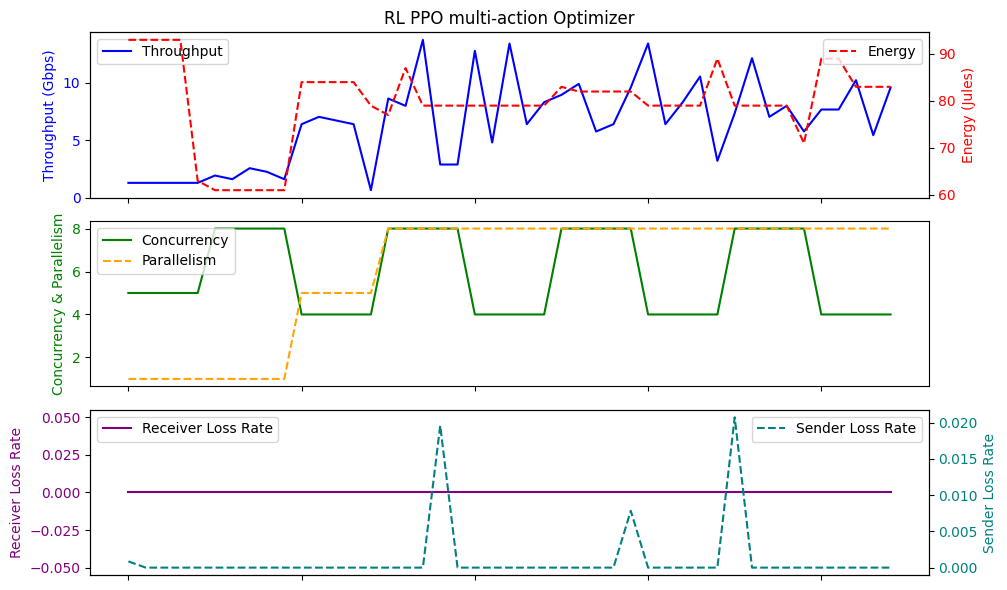

Average Throughput: 6.421333333333334
Total Energy: 3581.0
Total loss rate: 0.04903583322027997


In [28]:
######################################
############ RL
######################################
import sys
import copy
import random
import time
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback,CheckpointCallback,CallbackList
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

num_of_run=1

rl_2M_throughput_list=[]
rl_2M_energy_list=[]
rl_2M_plr_list=[]


model = PPO.load("./ppo_multi_action_in_de/ppo_best_model/best_model.zip")
for i in range(0,num_of_run):
    done = False
    episode_reward = 0
    env=transferClass_multi_action_increase_decrease(cluster_dictionary,initial_value_cluster_dictionary,'random')
    action_list=[]
    reward_list=[]
    obs = env.reset()
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        action_list.append(action)
    #     print("action: ",action)
        obs, reward, done, info = env.step(action)
    #     obs = obs.astype(np.float32)
    #     print("obs: ", obs,".... reward: ",reward)
        reward_list.append(reward)
        episode_reward += reward

    accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed
    env.close()
    print(accumulator_df.describe())
    print(f"Episode reward: {episode_reward}")
    print(f"actions {action_list},   {len(action_list)}")
    print(f"rewards {reward_list},  {len(reward_list)}")
#     print(f"Average Throughput {accumulator_df['Throughput'].mean()}")
#     print(f"Total Energy {accumulator_df['Energy'].sum()}")
#     print(f"Total packet loss {accumulator_df['SenderLR'].sum()}")
    rl_2M_throughput_list.append(accumulator_df['Throughput'].mean())
    rl_2M_energy_list.append(accumulator_df['Energy'].sum())
    rl_2M_plr_list.append(accumulator_df['SenderLR'].sum())
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

    df=accumulator_df.reset_index()
    # Top plot with Throughput and Energy
    ax1.plot( df['Throughput'], label='Throughput', color='blue')
    ax1.set_ylabel('Throughput (Gbps)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title('RL PPO multi-action Optimizer')

    ax2_twin = ax1.twinx()
    ax2_twin.plot(df['Energy'], label='Energy', color='red', linestyle='--')
    ax2_twin.set_ylabel('Energy (Jules)', color='red')
    ax2_twin.tick_params(axis='y', labelcolor='red')

    # Bottom plot with Concurrency, Parallelism, and CC
    ax2.plot(df['Concurrency'], label='Concurrency', color='green')
    ax2.plot(df['Parallelism'], label='Parallelism', color='orange', linestyle='--')
    ax2.set_ylabel('Concurrency & Parallelism', color='green')
    ax2.tick_params(axis='y', labelcolor='green')


    # Bottom plot with Receiver Loss Rate and Sender Loss Rate
    ax3.plot( df['LossRate'], label='Receiver Loss Rate', color='purple', linestyle='-')
    ax3.set_ylabel('Receiver Loss Rate', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')

    ax4_twin = ax3.twinx()
    ax4_twin.plot( df['SenderLR'], label='Sender Loss Rate', color='teal', linestyle='--')
    ax4_twin.set_ylabel('Sender Loss Rate', color='teal')
    ax4_twin.tick_params(axis='y', labelcolor='teal')
#     ax4_twin.set_ylim(-5,25)

#     ax3.set_ylim(-5,25)

    # Formatting the x-axis to show time correctly
#     ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: (datetime.min + timedelta(seconds=x)).strftime('%H:%M:%S')))
#     ax2.set_xticklabels([])
    ax1.set_xticklabels([])
    ax2.set_xticklabels([])
    # Fix for overlapping layouts
    fig.tight_layout()

    # Legend
    ax1.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.legend(loc='upper left')
#     ax3_twin.legend(loc='upper right')
    ax3.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
#     plt.savefig('withBT.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

    average_throughput = df['Throughput'].mean()
    print("Average Throughput:", average_throughput)
    total_energy = df['Energy'].sum()
    print("Total Energy:", total_energy)
    total_plr = df['SenderLR'].sum()
    print("Total loss rate:", total_plr)